In [1]:
from fastai.vision.all import *
from fastai.distributed import *
from fastai.callback.tracker import SaveModelCallback
from fastprogress import fastprogress
from fastai.data import load

import torch
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision import datasets, transforms, models
from torchvision.transforms.functional import *

from models.utils.joiner2 import Joiner
from models.utils.new_losses import *
from models.utils.metrics import Accuracy
from models.utils.dataLoader import *
from models.utils.datasets import CustomCifar

from collections import defaultdict, deque
import itertools
import matplotlib.pyplot as plt
import numpy as np

from numba import jit, cuda
from timeit import default_timer as timer

In [2]:
import webdataset as wds
import torchvision
import sys

In [3]:
H = 32
W= 32
bs=5

transform = T.Compose([
T.Resize((H,W))#,
#T.ToTensor(),
#T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [4]:
path_train = 'data/GramCifar/valid'
entries = os.listdir(path_train)
entries.pop(0)
print(entries)

[]


In [5]:
db0 = torch.load(path_train+"/valid_CustomCifarlen10000_startIdx0.tar")

In [11]:
db0.transforms = transform

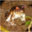

In [13]:
db0[0][0]

In [14]:
sink = wds.TarWriter("data/WebDataset-GramCifar/valid/GramCifar-0.tar")
i=0
while i<10000:
    for index, (input, output) in enumerate(db0):
        #print("sample%06d" % int(index+10000))
        i+1
        if index%1000==0:
            print(f"{index:6d}", end="\r", flush=True, file=sys.stderr)
        sink.write({
            "__key__": "sample%06d" % index,
            "input.pyd": input,
            "output.pyd": output,
        })
sink.close()

KeyError: 10000

In [8]:
!ls -l data/WebDataset-GramCifar/train/GramCifar.tar
!tar tvf data/WebDataset-GramCifar/train/GramCifar.tar | head

-rw-rw-r-- 1 atsumilab atsumilab 42014730240  6月  2 17:59 data/WebDataset-GramCifar/train/GramCifar.tar
-r--r--r-- bigdata/bigdata 3170 2021-06-02 17:55 sample000000.input.pyd
-r--r--r-- bigdata/bigdata 4194733 2021-06-02 17:55 sample000000.output.pyd
-r--r--r-- bigdata/bigdata    3170 2021-06-02 17:55 sample000001.input.pyd
-r--r--r-- bigdata/bigdata 4194733 2021-06-02 17:55 sample000001.output.pyd
-r--r--r-- bigdata/bigdata    3170 2021-06-02 17:55 sample000002.input.pyd
-r--r--r-- bigdata/bigdata 4194733 2021-06-02 17:55 sample000002.output.pyd
-r--r--r-- bigdata/bigdata    3170 2021-06-02 17:55 sample000003.input.pyd
-r--r--r-- bigdata/bigdata 4194733 2021-06-02 17:55 sample000003.output.pyd
-r--r--r-- bigdata/bigdata    3170 2021-06-02 17:55 sample000004.input.pyd
-r--r--r-- bigdata/bigdata 4194733 2021-06-02 17:55 sample000004.output.pyd
tar: write error


In [12]:
#start = timer()
#db1 = torch.load(path_train+"/"+entries[1])
#print("Loaded in", timer()-start)
db1 = 0
db2 = 0

In [ ]:
start = timer()
db3 = torch.load(path_train+"/"+entries[3])
print("Loaded in", timer()-start)

In [10]:
name = "0_20"
db = torch.utils.data.ConcatDataset([db,db2])
#torch.save(db, 'data/GramCifar/train/train_CustomCifar'+name+'.tar')

In [11]:
len(db)

30000

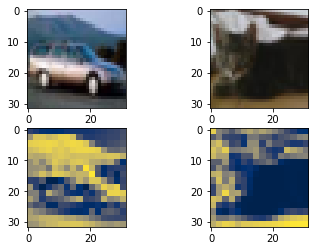

In [14]:
pix_h = 19
pix_w = 18
image = 4
#f, axs = plt.subplots(2,2,figsize=(8,8))
plt.subplot(221)
plt.imshow(db[image][0])#.cpu().permute(1, 2, 0))
plt.subplot(222)
plt.imshow(db[image+5][0])#.cpu().permute(1, 2, 0))
plt.subplot(223)
plt.imshow(db[image][1][0][pix_h,pix_w,...].cpu().detach().numpy(),cmap='cividis', interpolation='nearest')#,vmax=threshold)
plt.subplot(224)
plt.imshow(db[image+5][1][0][pix_h,pix_w,...].cpu().detach().numpy(),cmap='cividis', interpolation='nearest')

In [4]:
def CifarDataset(path_train, path_val=None, transforms=None, start_idx = 0): #
    if path_val == None:
        db = torch.load(path_train+"/"+entries[start_idx])
        db.transforms = transforms
        print(start_idx, "Block complete")
        for i in range(start_idx+1,start_idx+10):
        #for i in range(1,10):
            db1 = torch.load(path_train+"/"+entries[i])
            db1.transforms = transforms
            #datasets = [db,db1]
            db = torch.utils.data.ConcatDataset([db,db1])
            print(i, "Block complete")
        #db = torch.load(path_train)
                        
#         train_size = int(len(db)*0.8)
#         val_size = int(len(db)*0.2)
#         remainder = len(db)-train_size - val_size
#         train, valid, _ = torch.utils.data.random_split(db, [train_size, val_size, remainder])
        
#         train_dl = load.DataLoader(train,batch_size=5)
#         valid_dl = load.DataLoader(valid,batch_size=5)
#         dld = ImageDataLoaders(train_dl, valid_dl, device='cuda')
        
        return db

In [5]:
ds_train = CifarDataset(path_train, path_val=None, transforms=transform, start_idx = 40)

40 Block complete
41 Block complete
42 Block complete
43 Block complete
44 Block complete
45 Block complete
46 Block complete
47 Block complete
48 Block complete
49 Block complete


In [6]:
file_name = "len"+str(10000)+"_startIdx"+str(40)
torch.save(ds_train, 'data/GramCifar/train/train_CustomCifar'+file_name+'.tar')

In [3]:
class AssembleDataset(nn.Module):
    def __init__(self, hidden_dim=256):
        super().__init__()
        
    def forward(self, size, start_idx):
        ds_train = CustomCifar(path='./data', transforms=transform, size= size, start_idx=start_idx)
        return ds_train

In [4]:
dataset = AssembleDataset()
dataset = dataset.cuda()

In [9]:
size = 1000
max_size = 50000
max_size_list = []
for i in range(0,max_size+1,size):
    max_size_list.append(i)
#max_size_list

In [10]:
start = timer()
for s in max_size_list:
    ds_train = dataset(size,s)
    file_name = "len"+str(size)+"_startIdx"+str(s)
    torch.save(ds_train, 'data/GramCifar/train/train_CustomCifar'+file_name+'.tar')
print("Total time:", timer()-start) 

0 images complete in 0m 3s
50 images complete in 2m 22s
100 images complete in 4m 42s
150 images complete in 7m 1s
200 images complete in 9m 21s
250 images complete in 11m 41s
300 images complete in 14m 0s
350 images complete in 16m 19s
400 images complete in 18m 38s
450 images complete in 20m 57s
500 images complete in 23m 15s
550 images complete in 25m 34s
600 images complete in 27m 53s
650 images complete in 30m 12s
700 images complete in 32m 30s
750 images complete in 34m 49s
800 images complete in 37m 8s
850 images complete in 39m 27s
900 images complete in 41m 45s
950 images complete in 44m 4s
0 images complete in 0m 3s
50 images complete in 2m 22s
100 images complete in 4m 41s
150 images complete in 7m 1s
200 images complete in 9m 19s
250 images complete in 11m 38s
300 images complete in 13m 56s
350 images complete in 16m 15s
400 images complete in 18m 34s
450 images complete in 20m 53s
500 images complete in 23m 12s
550 images complete in 25m 30s
600 images complete in 27m 49s


500 images complete in 23m 12s
550 images complete in 25m 32s
600 images complete in 27m 51s
650 images complete in 30m 11s
700 images complete in 32m 30s
750 images complete in 34m 50s
800 images complete in 37m 9s
850 images complete in 39m 29s
900 images complete in 41m 49s
950 images complete in 44m 8s
0 images complete in 0m 3s
50 images complete in 2m 22s
100 images complete in 4m 41s
150 images complete in 7m 0s
200 images complete in 9m 20s
250 images complete in 11m 39s
300 images complete in 13m 58s
350 images complete in 16m 18s
400 images complete in 18m 37s
450 images complete in 20m 56s
500 images complete in 23m 15s
550 images complete in 25m 34s
600 images complete in 27m 53s
650 images complete in 30m 12s
700 images complete in 32m 32s
750 images complete in 34m 51s
800 images complete in 37m 11s
850 images complete in 39m 31s
900 images complete in 41m 50s
950 images complete in 44m 10s
0 images complete in 0m 3s
50 images complete in 2m 22s
100 images complete in 4m 

950 images complete in 44m 10s
0 images complete in 0m 3s
50 images complete in 2m 23s
100 images complete in 4m 42s
150 images complete in 7m 2s
200 images complete in 9m 22s
250 images complete in 11m 41s
300 images complete in 14m 1s
350 images complete in 16m 21s
400 images complete in 18m 40s
450 images complete in 20m 60s
500 images complete in 23m 19s
550 images complete in 25m 38s
600 images complete in 27m 57s
650 images complete in 30m 16s
700 images complete in 32m 36s
750 images complete in 34m 55s
800 images complete in 37m 15s
850 images complete in 39m 35s
900 images complete in 41m 56s
950 images complete in 44m 16s
0 images complete in 0m 3s
50 images complete in 2m 22s
100 images complete in 4m 42s
150 images complete in 7m 2s
200 images complete in 9m 21s
250 images complete in 11m 40s
300 images complete in 13m 59s
350 images complete in 16m 19s
400 images complete in 18m 38s
450 images complete in 20m 57s
500 images complete in 23m 17s
550 images complete in 25m 36

400 images complete in 18m 34s
450 images complete in 20m 53s
500 images complete in 23m 12s
550 images complete in 25m 31s
600 images complete in 27m 50s
650 images complete in 30m 9s
700 images complete in 32m 28s
750 images complete in 34m 47s
800 images complete in 37m 6s
850 images complete in 39m 25s
900 images complete in 41m 44s
950 images complete in 44m 4s
0 images complete in 0m 3s
50 images complete in 2m 23s
100 images complete in 4m 42s
150 images complete in 7m 1s
200 images complete in 9m 20s
250 images complete in 11m 39s
300 images complete in 13m 58s
350 images complete in 16m 17s
400 images complete in 18m 36s
450 images complete in 20m 55s
500 images complete in 23m 15s
550 images complete in 25m 34s
600 images complete in 27m 54s
650 images complete in 30m 14s
700 images complete in 32m 33s
750 images complete in 34m 53s
800 images complete in 37m 12s
850 images complete in 39m 32s
900 images complete in 41m 51s
950 images complete in 44m 11s
0 images complete in 

IndexError: index 50000 is out of bounds for axis 0 with size 50000

6